In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn import metrics
import copy

In [14]:
class Layer():
    def __init__(self) -> None:
        self.neurons = []
    
    def __init__(self, num_in: int, num_out: int, weights: list, biases: list) -> None:
        self.num_in = num_in
        self.num_out = num_out
        self.weights = np.array(weights).reshape(num_in, num_out)
        self.biases = np.array(biases).reshape(1, num_out)
        self.rmsprop_w = 0
        self.rmsprop_b = 0
        self.momentum_w = 0
        self.momentum_b = 0
        
    def evaluate(self, input: list) -> list:
        self.input = np.array(input)
        self.z_values = self.input @ self.weights + self.biases
        self.activations = self.activate(self.z_values)
        return self.activations
    
    def __repr__(self) -> str:
        return "Layer(" + str(self.neurons) + ")"
    
    def activate(self, x):
        pass
    
    def gradient(self, x):
        pass
    

class LinearLayer(Layer):
    def activate(self, x):
        return x
    
    def gradient(self, x):
        return np.ones(x.shape)
    
class SigmoidLayer(Layer):
    def activate(self, x):
        return np.exp(x) / (1 + np.exp(x))
    
    def gradient(self, x):
        return self.activate(x) * (1 - self.activate(x))

class TanhLayer(Layer):
    def activate(self, x):
        return (np.exp(x) - np.exp(-x)) / (np.exp(x) + np.exp(-x))
    
    def gradient(self, x):
        return 1.0 - self.activate(x)**2

class ReluLayer(Layer):
    def activate(self, x):
        return np.maximum(x, 0)
    
    def gradient(self, x):
        return np.where(x > 0, 1, 0)

class SoftmaxLayer(Layer):
    def activate(self, x):
        e_x = np.exp(x.T - np.max(x, axis=1).T).T
        return (e_x.T / e_x.sum(axis=1).T).T

In [124]:
from sklearn.metrics import *
from graphviz import Digraph
import random
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import copy

class Network:
    def __init__(self) -> None:
        self.layers = []
        self.size = []
        self.s = None
    
    def __repr__(self) -> str:
        return "Network(" + "\n\t".join([str(layer) for layer in self.layers]) + ")"
    
    def __init__(self, layer_types: list, size: list, weights=None,biases=None, gen_type="0|1", norm=True, cat=False) -> None:
        assert len(layer_types) == len(size) - 1, "Invalid matrix dimension"
        self.layers = []
        self.size = size
        self.norm = norm
        self.cat = cat
        for i, layer_type in enumerate(layer_types):
            if layer_type == "sigmoid":
                self.addLayerBack(SigmoidLayer(
                    size[i],
                    size[i + 1],
                    weights[i] if weights else Network.generate(gen_type, (size[i], size[i+1])),
                    biases[i] if biases else Network.generate(gen_type, (size[i+1], 1))))
            elif layer_type == "linear":
                self.addLayerBack(LinearLayer(
                    size[i],
                    size[i + 1],
                    weights[i] if weights else Network.generate(gen_type, (size[i], size[i+1])),
                    biases[i] if biases else Network.generate(gen_type, (size[i+1], 1))))
            elif layer_type == "relu":
                self.addLayerBack(ReluLayer(
                    size[i],
                    size[i + 1],
                    weights[i] if weights else Network.generate(gen_type, (size[i], size[i+1])),
                    biases[i] if biases else Network.generate(gen_type, (size[i+1], 1))))
            elif layer_type == "tanh":
                self.addLayerBack(TanhLayer(
                    size[i],
                    size[i + 1],
                    weights[i] if weights else Network.generate(gen_type, (size[i], size[i+1])),
                    biases[i] if biases else Network.generate(gen_type, (size[i+1], 1))))
            elif layer_type == "softmax":
                self.addLayerBack(SoftmaxLayer(
                    size[i],
                    size[i + 1],
                    weights[i] if weights else Network.generate(gen_type, (size[i], size[i+1])),
                    biases[i] if biases else Network.generate(gen_type, (size[i+1], 1))))
            else:
                logging.error("Invalid layer type")
    
    @staticmethod
    def batch_partition(list_in, n):
        l = copy.deepcopy(list_in)
        random.shuffle(l)
        return [l[(i * n):(i * n + n)] for i in range(int((len(l) + n - 1) / n))]
    
    @staticmethod
    def substr(a, b):
        return [a[i] - b[i] for i in range(len(a))]
    
    @staticmethod
    def generate(gen_type: str, n: tuple) -> np.array:
        if gen_type == "0|1":
            return np.random.uniform(0, 1, n)
        elif gen_type == "-1|1":
            return np.random.uniform(-1, 1, n)
        elif gen_type == "norm":
            return np.random.normal(0, 1, n)
        elif gen_type == "zero":
            return np.zeros(n)
        
    
    def addLayerBack(self, layer: Layer) -> None:
        self.layers.append(layer)
    
    def forward(self, x: list) -> list:
        input = x
        for layer in self.layers:
            input = layer.evaluate(input)
        return input
    
    def predict(self, x):
        out = self.forward(x)
        if self.norm:
            out = self.s.inverse_transform(out)
        if self.cat:
            return [np.argmax(o) for o in out]
        return out
            
    def backward_propagate_error(self, y):
        deltas = [None] * len(self.layers)
        
        for i in reversed(range(len(self.layers))):
            layer = self.layers[i]
            
            if layer == self.layers[-1]:
                if type(layer) == SoftmaxLayer:
                    out = []
                    for elem_x, elem_y in zip(layer.activations, y):
                        error = elem_y - elem_x
                        x = elem_x.reshape(elem_x.shape[0], )
                        si_sj = - x * x.reshape(layer.num_out, 1)
                        s_der = np.diag(x) + si_sj
                        out.append(s_der @ error)

                    out = np.array(out)
                    layer.deltas = copy.deepcopy(out)

                else:
                    layer.deltas = y - layer.activations
            else:
                next_layer = self.layers[i+1]
                layer.deltas = ((next_layer.weights @ next_layer.deltas.T) * layer.gradient(layer.z_values).T).T

        m = y.shape[0]
        
        for layer in self.layers:
            layer.der_w = (layer.deltas.T @ layer.input).T / m
            layer.der_b = (layer.deltas.T @ np.ones((m, 1))).T / m
    
    def clean_params(self):
        for idx, layer in enumerate(self.layers):
            for neuron in layer.neurons:
                neuron.output = 0
                neuron.deltas = [0 for i in range(len(neuron.weights))]
    
    def update_weights(self, l_rate, momentum=False, m_lambda=0.1, rmsprop=False, rms_beta=0.9, reg_lambda=0.0):
        for layer in self.layers:
            if momentum:
                layer.momentum_w = layer.momentum_w * m_lambda + layer.der_w
                layer.weights = layer.weights + l_rate * layer.momentum_w
                layer.momentum_b = layer.momentum_b * m_lambda + layer.der_b
                layer.biases = layer.biases + l_rate * layer.momentum_b

            elif rmsprop:
                layer.rmsprop_w = rms_beta * layer.rmsprop_w + (1 - rms_beta) * layer.der_w ** 2
                layer.weights = layer.weights + l_rate * (layer.der_w / np.sqrt(layer.rmsprop_w))
                layer.rmsprop_b = rms_beta * layer.rmsprop_b + (1 - rms_beta) * layer.der_b ** 2
                layer.biases = layer.biases + l_rate * (layer.der_b / np.sqrt(layer.rmsprop_b))

            else:
                layer.weights = (1.0 - reg_lambda) * layer.weights + l_rate * layer.der_w
                layer.biases = (1.0 - reg_lambda) * layer.biases + l_rate * layer.der_b
                    
    
    def train_network(self, train_data: list, train_y: list, l_rate=1e-3, n_epoch=5, batch_size=None,
                     momentum=False, m_lambda=0.1, rmsprop=False, rms_beta=0.9, valid_x=None, valid_y=None,
                     reg_lambda=0.0) -> None:
        errors = []
        oks = []
        y_std = train_y
        last_val_score = float("inf")
        cnt = 0
        if self.norm:
            self.s = StandardScaler()
            y_std = self.s.fit_transform(train_y)
        elif self.cat:
            max_y = np.max(y_std)
            y_std = np.array([[1 if i == y[0] else 0 for i in range(max_y + 1)] for y in train_y])
        for epoch in range(n_epoch):
            sum_error = 0
            ok = 0
            p = np.random.permutation(len(train_y))
            x = train_data[p]
            y = y_std[p]
            i = 0

            while i < len(y):
                x_batch = x[i:i + batch_size]
                y_batch = y[i:i + batch_size]
                i = i + batch_size
#                 self.clean_params()
                outputs = self.forward(x_batch)
                if self.cat:
                    ok += accuracy_score([np.argmax(o) for o in y_batch], [np.argmax(o) for o in outputs]) * len(y_batch)
                sum_error += mean_squared_error(y_batch, outputs) * len(y_batch)
                
                self.backward_propagate_error(y_batch)
                self.update_weights(l_rate, momentum, m_lambda, rmsprop, rms_beta, reg_lambda)

            errors.append(sum_error)
            oks.append(ok)
            if valid_x is not None and valid_y is not None:
                y_pred = self.predict(valid_x)
                y_pred = np.squeeze(y_pred)
                score = mean_squared_error(y_pred, valid_y)
                if score > last_val_score:
                    cnt += 1
                if cnt > 5:
                    break
                last_val_score = score
#             print('>epoch=%d, lrate=%.3f, error=%.3f' % (epoch, l_rate, sum_error))
        return (errors, oks)
        

# tests
network = Network(["linear"], [2, 1], [[[2,3]]], [[1]])
assert network.forward([[2,3]]) == [[14]]

network2 = Network(["linear"], [1, 2], [
        [[2], [3]]
], [[[1], [2]]])
assert np.array_equal(network2.forward([[5]]), [[11, 17]])

# multimodal-sparse
## bez przeciwdziałania overfittingowi

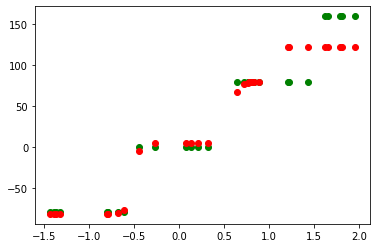

In [186]:
from sklearn.model_selection import train_test_split

train_df = pd.read_csv('./mio1/regression/multimodal-sparse-training.csv', index_col=0)
test_df = pd.read_csv('./mio1/regression/multimodal-sparse-test.csv', index_col=0)

x_train, x_valid, y_train, y_valid = train_test_split(np.expand_dims(train_df['x'], 1), np.expand_dims(train_df['y'], 1))

np.random.seed(2137)
mlp = Network(["sigmoid", "linear"], [1,10,1], norm=False)
mlp_err, mlp_ok = mlp.train_network(x_train, y_train, n_epoch=100, l_rate=0.1, batch_size=8)

y_pred = mlp.predict(x_train)
y_pred = np.squeeze(y_pred)
plt.scatter(x_train, y_train, color='green')
plt.scatter(x_train, y_pred, color='red')

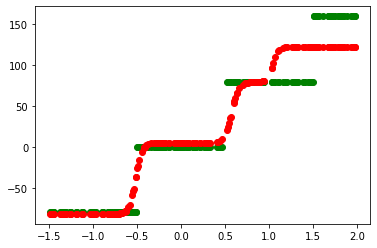

In [187]:
y_pred = mlp.predict(np.expand_dims(test_df['x'], 1))
y_pred = np.squeeze(y_pred)
plt.scatter(test_df['x'], test_df['y'], color='green')
plt.scatter(test_df['x'], y_pred, color='red')

## ze zbiorem walidacyjnym

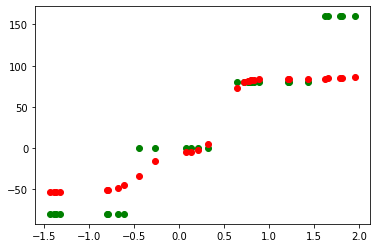

In [188]:
np.random.seed(2137)
mlp_valid = Network(["sigmoid", "linear"], [1,10,1], norm=False)
mlp_valid_err, mlp_valid_ok = mlp_valid.train_network(x_train, y_train, n_epoch=100, l_rate=0.1, batch_size=8, valid_x=x_valid, valid_y=y_valid)

y_pred = mlp_valid.predict(x_train)
y_pred = np.squeeze(y_pred)
plt.scatter(x_train, y_train, color='green')
plt.scatter(x_train, y_pred, color='red')

## z regularyzacją L2

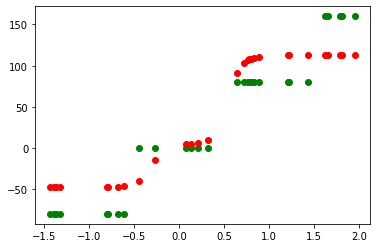

In [189]:
np.random.seed(2137)
mlp_reg = Network(["sigmoid", "linear"], [1,10,1], norm=False)
mlp_reg_err, mlp_reg_ok = mlp_reg.train_network(x_train, y_train, n_epoch=100, l_rate=0.1, batch_size=8, reg_lambda=0.01)

y_pred = mlp_reg.predict(x_train)
y_pred = np.squeeze(y_pred)
plt.scatter(x_train, y_train, color='green')
plt.scatter(x_train, y_pred, color='red')

### Błąd na zbiorze treningowym podczas uczenia

(0.0, 40000.0)

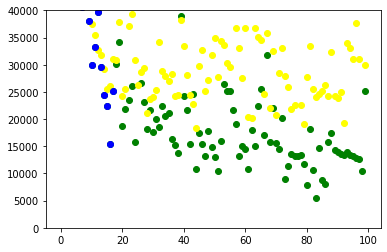

In [190]:
plt.scatter(range(len(mlp_err)), mlp_err, color='green')
plt.scatter(range(len(mlp_reg_err)), mlp_reg_err, color='yellow')
plt.scatter(range(len(mlp_valid_err)), mlp_valid_err, color='blue')
plt.ylim(0, 40000)

### Błędy na zbiorze testowym (MSE)

In [191]:
y_pred = mlp.predict(np.expand_dims(test_df['x'], 1))
y_pred = np.squeeze(y_pred)
print("bez przeciwdziałania:", mean_squared_error(y_pred, test_df['y']))
y_pred = mlp_valid.predict(np.expand_dims(test_df['x'], 1))
y_pred = np.squeeze(y_pred)
print("ze zbiorem walidacyjnym:", mean_squared_error(y_pred, test_df['y']))
y_pred = mlp_reg.predict(np.expand_dims(test_df['x'], 1))
y_pred = np.squeeze(y_pred)
print("z regularyzacją:", mean_squared_error(y_pred, test_df['y']))

bez przeciwdziałania: 525.1776090268229
ze zbiorem walidacyjnym: 1225.043764953033
z regularyzacją: 959.6304038517513


# rings5-sparse

Text(0.5, 1.0, 'Train split')

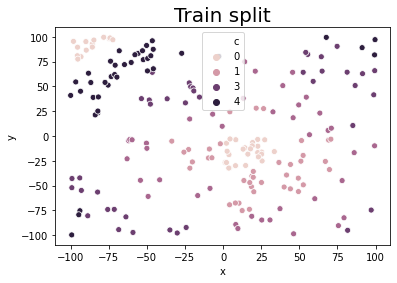

In [192]:
train_df = pd.read_csv('./mio1/classification/rings5-sparse-training.csv')
test_df = pd.read_csv('./mio1/classification/rings5-sparse-test.csv')
sns.scatterplot(x='x', y='y', hue='c', data=train_df)
plt.title('Train split', fontsize=20)

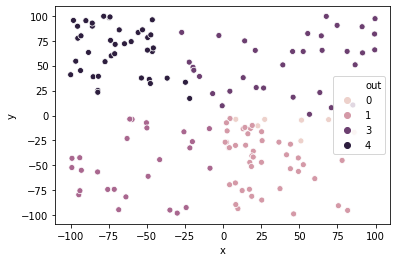

In [193]:
x_train, x_valid, y_train, y_valid = train_test_split(train_df[['x', 'y']].to_numpy(), np.expand_dims(train_df['c'], 1))

np.random.seed(2137)
mlp = Network(["sigmoid", "softmax"], [2,10,5], norm=False, cat=True)
mlp_err, mlp_ok = mlp.train_network(x_train, y_train, n_epoch=100, l_rate=0.1, batch_size=32)

y_pred = mlp.predict(x_train)
y_pred = np.squeeze(y_pred)

tmp_df = pd.DataFrame({'x': x_train[:, 0], 'y': x_train[:, 1]})
tmp_df['out'] = y_pred
sns.scatterplot(x='x', y='y', hue='out', data=tmp_df)

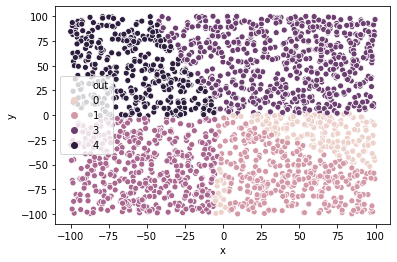

In [194]:
y_pred = mlp.predict(test_df[['x', 'y']].to_numpy())
y_pred = np.squeeze(y_pred)
test_df['out'] = y_pred
sns.scatterplot(x='x', y='y', hue='out', data=test_df)

## ze zbiorem walidacyjnym

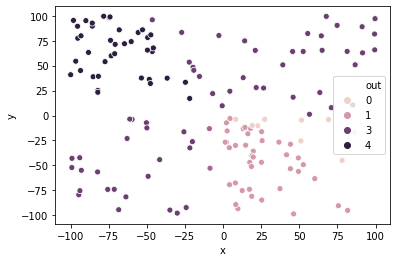

In [195]:
np.random.seed(2137)
mlp_valid = Network(["sigmoid", "softmax"], [2,10,5], norm=False, cat=True)
mlp_valid_err, mlp_valid_ok = mlp_valid.train_network(x_train, y_train, n_epoch=100, l_rate=0.1, batch_size=8, valid_x=x_valid, valid_y=y_valid)

y_pred = mlp_valid.predict(x_train)
y_pred = np.squeeze(y_pred)
tmp_df['out'] = y_pred
sns.scatterplot(x='x', y='y', hue='out', data=tmp_df)

## z regularyzacją L2

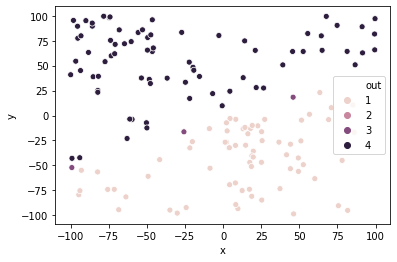

In [196]:
np.random.seed(2137)
mlp_reg = Network(["sigmoid", "softmax"], [2,10,5], norm=False, cat=True)
mlp_reg_err, mlp_reg_ok = mlp_reg.train_network(x_train, y_train, n_epoch=100, l_rate=0.1, batch_size=8, reg_lambda=0.01)

y_pred = mlp_reg.predict(x_train)
y_pred = np.squeeze(y_pred)
tmp_df['out'] = y_pred
sns.scatterplot(x='x', y='y', hue='out', data=tmp_df)

### Błąd na zbiorze treningowym podczas uczenia

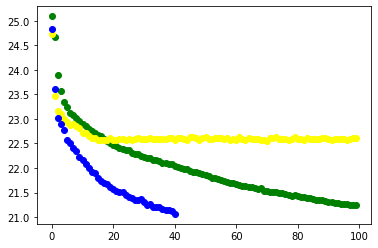

In [197]:
plt.scatter(range(len(mlp_err)), mlp_err, color='green')
plt.scatter(range(len(mlp_reg_err)), mlp_reg_err, color='yellow')
plt.scatter(range(len(mlp_valid_err)), mlp_valid_err, color='blue')

### Skuteczność na zbiorze testowym (accuracy)

In [198]:
y_pred = mlp.predict(test_df[['x', 'y']].to_numpy())
y_pred = np.squeeze(y_pred)
print("bez przeciwdziałania:", accuracy_score(y_pred, test_df['c']))
y_pred = mlp_valid.predict(test_df[['x', 'y']].to_numpy())
y_pred = np.squeeze(y_pred)
print("ze zbiorem walidacyjnym:", accuracy_score(y_pred, test_df['c']))
y_pred = mlp_reg.predict(test_df[['x', 'y']].to_numpy())
y_pred = np.squeeze(y_pred)
print("z regularyzacją:", accuracy_score(y_pred, test_df['c']))

bez przeciwdziałania: 0.384
ze zbiorem walidacyjnym: 0.4075
z regularyzacją: 0.2315


# rings3-balance

Text(0.5, 1.0, 'Train split')

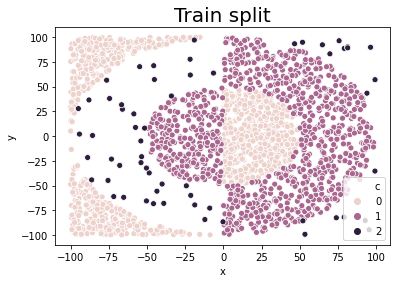

In [199]:
train_df = pd.read_csv('./mio1/classification/rings3-balance-training.csv')
test_df = pd.read_csv('./mio1/classification/rings3-balance-test.csv')
sns.scatterplot(x='x', y='y', hue='c', data=train_df)
plt.title('Train split', fontsize=20)

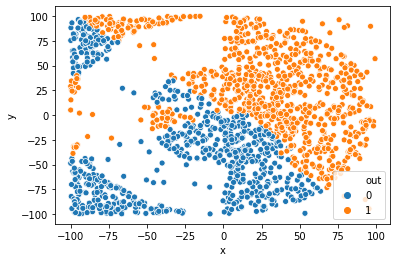

In [200]:
x_train, x_valid, y_train, y_valid = train_test_split(train_df[['x', 'y']].to_numpy(), np.expand_dims(train_df['c'], 1))

np.random.seed(2137)
mlp = Network(["sigmoid", "softmax"], [2,10,3], norm=False, cat=True)
mlp_err, mlp_ok = mlp.train_network(x_train, y_train, n_epoch=100, l_rate=0.1, batch_size=32)

y_pred = mlp.predict(x_train)
y_pred = np.squeeze(y_pred)

tmp_df = pd.DataFrame({'x': x_train[:, 0], 'y': x_train[:, 1]})
tmp_df['out'] = y_pred
sns.scatterplot(x='x', y='y', hue='out', data=tmp_df)

0.3765


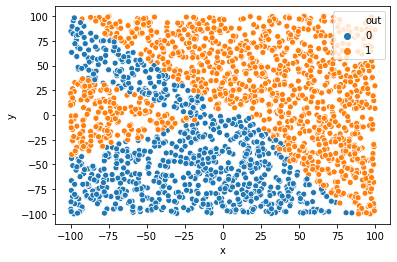

In [201]:
y_pred = mlp.predict(test_df[['x', 'y']].to_numpy())
y_pred = np.squeeze(y_pred)
print(metrics.accuracy_score(y_pred, test_df['c']))
test_df['out'] = y_pred
sns.scatterplot(x='x', y='y', hue='out', data=test_df)

## ze zbiorem walidacyjnym

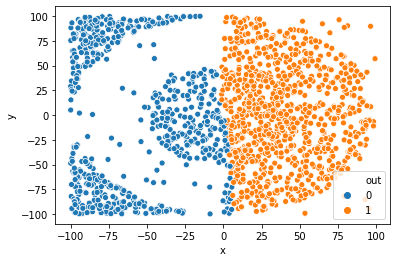

In [202]:
np.random.seed(2137)
mlp_valid = Network(["sigmoid", "softmax"], [2,10,3], norm=False, cat=True)
mlp_valid_err, mlp_valid_ok = mlp_valid.train_network(x_train, y_train, n_epoch=100, l_rate=0.1, batch_size=8, valid_x=x_valid, valid_y=y_valid)

y_pred = mlp_valid.predict(x_train)
y_pred = np.squeeze(y_pred)
tmp_df['out'] = y_pred
sns.scatterplot(x='x', y='y', hue='out', data=tmp_df)

## z regularyzacją L2

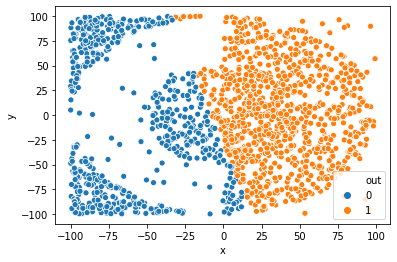

In [203]:
np.random.seed(2137)
mlp_reg = Network(["sigmoid", "softmax"], [2,10,3], norm=False, cat=True)
mlp_reg_err, mlp_reg_ok = mlp_reg.train_network(x_train, y_train, n_epoch=100, l_rate=0.1, batch_size=8, reg_lambda=0.01)

y_pred = mlp_reg.predict(x_train)
y_pred = np.squeeze(y_pred)
tmp_df['out'] = y_pred
sns.scatterplot(x='x', y='y', hue='out', data=tmp_df)

### Błąd na zbiorze treningowym podczas uczenia

(100.0, 300.0)

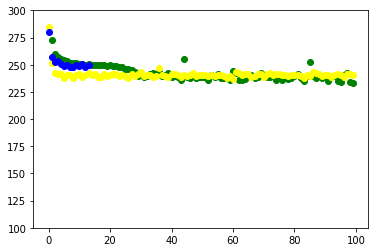

In [204]:
plt.scatter(range(len(mlp_err)), mlp_err, color='green')
plt.scatter(range(len(mlp_reg_err)), mlp_reg_err, color='yellow')
plt.scatter(range(len(mlp_valid_err)), mlp_valid_err, color='blue')
plt.ylim(100, 300)

### Skuteczność na zbiorze testowym (accuracy)

In [205]:
y_pred = mlp.predict(test_df[['x', 'y']].to_numpy())
y_pred = np.squeeze(y_pred)
print("bez przeciwdziałania:", accuracy_score(y_pred, test_df['c']))
y_pred = mlp_valid.predict(test_df[['x', 'y']].to_numpy())
y_pred = np.squeeze(y_pred)
print("ze zbiorem walidacyjnym:", accuracy_score(y_pred, test_df['c']))
y_pred = mlp_reg.predict(test_df[['x', 'y']].to_numpy())
y_pred = np.squeeze(y_pred)
print("z regularyzacją:", accuracy_score(y_pred, test_df['c']))

bez przeciwdziałania: 0.3765
ze zbiorem walidacyjnym: 0.405
z regularyzacją: 0.4095


# xor3-balance

Text(0.5, 1.0, 'Train split')

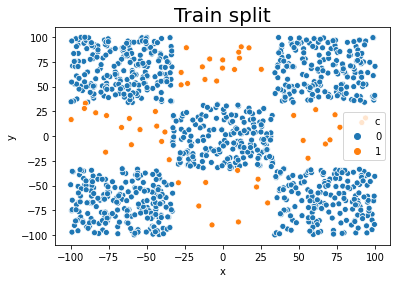

In [206]:
train_df = pd.read_csv('./mio1/classification/xor3-balance-training.csv')
test_df = pd.read_csv('./mio1/classification/xor3-balance-test.csv')
sns.scatterplot(x='x', y='y', hue='c', data=train_df)
plt.title('Train split', fontsize=20)

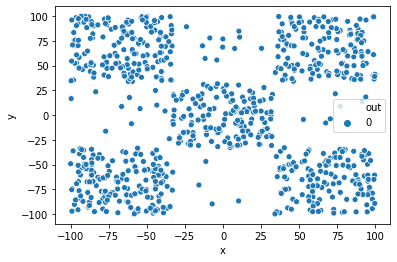

In [207]:
x_train, x_valid, y_train, y_valid = train_test_split(train_df[['x', 'y']].to_numpy(), np.expand_dims(train_df['c'], 1))

np.random.seed(2137)
mlp = Network(["sigmoid", "softmax"], [2,10,2], norm=False, cat=True)
mlp_err, mlp_ok = mlp.train_network(x_train, y_train, n_epoch=100, l_rate=0.1, batch_size=32)

y_pred = mlp.predict(x_train)
y_pred = np.squeeze(y_pred)

tmp_df = pd.DataFrame({'x': x_train[:, 0], 'y': x_train[:, 1]})
tmp_df['out'] = y_pred
sns.scatterplot(x='x', y='y', hue='out', data=tmp_df)

0.5525


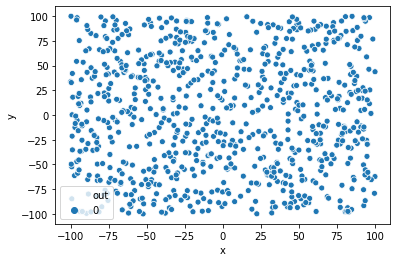

In [208]:
y_pred = mlp.predict(test_df[['x', 'y']].to_numpy())
y_pred = np.squeeze(y_pred)
print(metrics.accuracy_score(y_pred, test_df['c']))
test_df['out'] = y_pred
sns.scatterplot(x='x', y='y', hue='out', data=test_df)

## ze zbiorem walidacyjnym

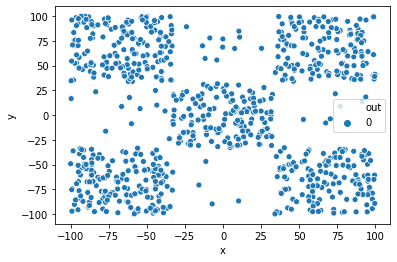

In [209]:
np.random.seed(2137)
mlp_valid = Network(["sigmoid", "softmax"], [2,10,2], norm=False, cat=True)
mlp_valid_err, mlp_valid_ok = mlp_valid.train_network(x_train, y_train, n_epoch=100, l_rate=0.1, batch_size=8, valid_x=x_valid, valid_y=y_valid)

y_pred = mlp_valid.predict(x_train)
y_pred = np.squeeze(y_pred)
tmp_df['out'] = y_pred
sns.scatterplot(x='x', y='y', hue='out', data=tmp_df)

## z regularyzacją L2

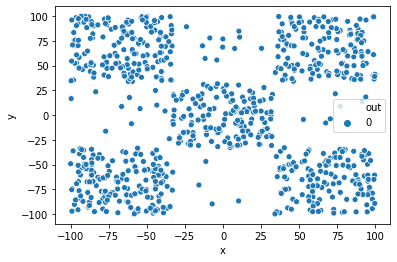

In [210]:
np.random.seed(2137)
mlp_reg = Network(["sigmoid", "softmax"], [2,10,2], norm=False, cat=True)
mlp_reg_err, mlp_reg_ok = mlp_reg.train_network(x_train, y_train, n_epoch=100, l_rate=0.1, batch_size=8, reg_lambda=0.01)

y_pred = mlp_reg.predict(x_train)
y_pred = np.squeeze(y_pred)
tmp_df['out'] = y_pred
sns.scatterplot(x='x', y='y', hue='out', data=tmp_df)

### Błąd na zbiorze treningowym podczas uczenia

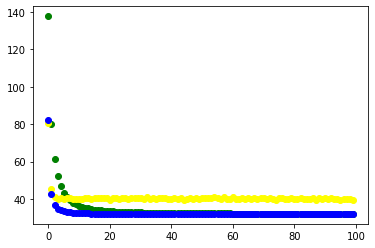

In [211]:
plt.scatter(range(len(mlp_err)), mlp_err, color='green')
plt.scatter(range(len(mlp_reg_err)), mlp_reg_err, color='yellow')
plt.scatter(range(len(mlp_valid_err)), mlp_valid_err, color='blue')

### Skuteczność na zbiorze testowym (accuracy)

In [212]:
y_pred = mlp.predict(test_df[['x', 'y']].to_numpy())
y_pred = np.squeeze(y_pred)
print("bez przeciwdziałania:", accuracy_score(y_pred, test_df['c']))
y_pred = mlp_valid.predict(test_df[['x', 'y']].to_numpy())
y_pred = np.squeeze(y_pred)
print("ze zbiorem walidacyjnym:", accuracy_score(y_pred, test_df['c']))
y_pred = mlp_reg.predict(test_df[['x', 'y']].to_numpy())
y_pred = np.squeeze(y_pred)
print("z regularyzacją:", accuracy_score(y_pred, test_df['c']))

bez przeciwdziałania: 0.5525
ze zbiorem walidacyjnym: 0.5525
z regularyzacją: 0.5525
